# Swin-UNet Fetal Head Segmentation + HC Pipeline
This notebook implements a strong Swin-UNet segmentation pipeline using filled masks, Dice+BCE loss, and ellipse-based HC estimation.

In [1]:
# ================= Imports =================
import os, math, cv2
import json
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import timm
from torchvision.transforms import functional as TF
from torchvision import transforms
import matplotlib.pyplot as plt
# albumentations for synchronized image+mask augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

# ---- Canonical helpers (define once to override duplicates) ----
import math
def canonical_clean_mask(mask):
    mask = (mask > 0).astype(np.uint8)
    mask_blur = cv2.GaussianBlur(mask * 255, (7,7), 0)
    _, mask_bin = cv2.threshold(mask_blur, 127, 255, cv2.THRESH_BINARY)
    mask_bin = mask_bin // 255
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask_bin, 8)
    if num_labels <= 1:
        return None
    largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
    clean = (labels == largest_label).astype(np.uint8)
    contours, _ = cv2.findContours(clean, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    filled = np.zeros_like(clean)
    cv2.drawContours(filled, contours, -1, 1, thickness=-1)
    return filled

def canonical_mask_to_ellipse(mask):
    mask = (mask > 0).astype(np.uint8) * 255
    mask = cv2.GaussianBlur(mask, (9, 9), 0)
    _, mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if len(contours) == 0:
        return None
    cnt = max(contours, key=cv2.contourArea)
    if len(cnt) < 5:
        return None
    ellipse = cv2.fitEllipse(cnt)
    return ellipse

def canonical_hc_from_ellipse(ellipse):
    (_, _), (MA, ma), _ = ellipse
    a = MA / 2.0
    b = ma / 2.0
    if a <= 0 or b <= 0:
        return None
    h = ((a - b) ** 2) / ((a + b) ** 2 + 1e-8)
    circ = math.pi * (a + b) * (1 + (3 * h) / (10 + math.sqrt(4 - 3 * h)))
    return circ

# Create simple wrappers with historical names so existing cells keep working
def clean_mask(mask):
    return canonical_clean_mask(mask)
def mask_to_ellipse(mask):
    return canonical_mask_to_ellipse(mask)
def hc_from_ellipse(ellipse):
    return canonical_hc_from_ellipse(ellipse)
def ellipse_and_hc(mask):
    ellipse = canonical_mask_to_ellipse(mask)
    if ellipse is None:
        return None, None
    return ellipse, canonical_hc_from_ellipse(ellipse)

c:\Users\yasha\Desktop\research-paper2\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
IMG_SIZE = 256
BATCH_SIZE = 4
EPOCHS = 15         
LR = 5e-5          
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'


In [3]:
# ================= Mask Filling =================
def load_and_fill_mask(mask_path):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    _, bin_mask = cv2.threshold(mask, 5, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(bin_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    filled = np.zeros_like(bin_mask)
    cv2.drawContours(filled, contours, -1, 255, thickness=-1)
    return filled.astype(np.float32) / 255.0


In [4]:
class ResizeWithPad:
    def __init__(self, size=256):
        self.size = size

    def __call__(self, img):
        if not isinstance(img, Image.Image):
            img = TF.to_pil_image(img)

        w, h = img.size

        scale = self.size / max(w, h)
        new_w = int(w * scale)
        new_h = int(h * scale)

        img = TF.resize(img, (new_h, new_w))

        pad_w = self.size - new_w
        pad_h = self.size - new_h

        padding = (
            pad_w // 2,
            pad_h // 2,
            pad_w - pad_w // 2,
            pad_h - pad_h // 2
        )

        img = TF.pad(img, padding, fill=0)
        return img


In [5]:
img_tfms = transforms.Compose([
    ResizeWithPad(256),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


# ---------- Mask transforms ----------
mask_tfms = transforms.Compose([
    ResizeWithPad(256),
    transforms.ToTensor()
])

In [6]:
class TrainDataset(Dataset):
    def __init__(self, img_dir, csv_path, indices=None, augmentations=None):
        self.img_dir = img_dir
        self.df = pd.read_csv(csv_path)
        if indices is not None:
            self.df = self.df.iloc[indices].reset_index(drop=True)
        self.augmentations = augmentations

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        img_path = os.path.join(self.img_dir, row["filename"])
        mask_path = img_path.replace(".png", "_Annotation.png")

        img = Image.open(img_path).convert("RGB")
        filled = load_and_fill_mask(mask_path)
        mask_np = (filled * 255).astype(np.uint8)
        img_np = np.array(img)

        # ---- apply synchronized augmentations (albumentations) if provided ----
        if self.augmentations is not None:
            aug = self.augmentations(image=img_np, mask=mask_np)
            img_np = aug['image']
            mask_np = aug['mask']
        else:
            # fallback: resize+pad using existing transforms
            img = Image.fromarray(img_np)
            img = img_tfms(img)
            mask = Image.fromarray(mask_np)
            mask = mask_tfms(mask)
            mask = (mask > 0).float()
            hc = torch.tensor(row["head circumference (mm)"], dtype=torch.float32)
            pixel_size = torch.tensor(row["pixel size(mm)"], dtype=torch.float32)
            # orig sizes
            orig_h, orig_w = img_np.shape[0], img_np.shape[1]
            return img, mask, hc, pixel_size, orig_w, orig_h

        # ---- numpy -> tensor (channels-first) and normalize using torchvision stats ----
        img_tensor = transforms.ToTensor()(img_np)
        img_tensor = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229,0.224,0.225])(img_tensor)
        mask_tensor = torch.from_numpy((mask_np > 127).astype(np.float32)).unsqueeze(0)

        hc = torch.tensor(row["head circumference (mm)"], dtype=torch.float32)
        pixel_size = torch.tensor(row["pixel size(mm)"], dtype=torch.float32)
        orig_h, orig_w = img_np.shape[0], img_np.shape[1]

        return img_tensor, mask_tensor, hc, pixel_size, orig_w, orig_h


In [7]:

class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()

        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),

            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.block(x)


In [8]:

# ================= Swin-UNet =================
class SwinUNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = timm.create_model(
            'swin_tiny_patch4_window7_224',
            pretrained=True,
            features_only=True,
            img_size=256
        )

        ch = self.encoder.feature_info.channels()
        # ch = [96, 192, 384, 768] typically

        # ---------- Upsampling ----------
        self.up4 = nn.ConvTranspose2d(ch[3], ch[2], 2, 2)
        self.up3 = nn.ConvTranspose2d(ch[2], ch[1], 2, 2)
        self.up2 = nn.ConvTranspose2d(ch[1], ch[0], 2, 2)
        self.up1 = nn.ConvTranspose2d(ch[0], 64, 2, 2)

        # ---------- Refinement after skip fusion ----------
        self.ref4 = ConvBlock(ch[2] * 2, ch[2])
        self.ref3 = ConvBlock(ch[1] * 2, ch[1])
        self.ref2 = ConvBlock(ch[0] * 2, ch[0])
        self.ref1 = ConvBlock(64, 64)

        self.head = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        feats = self.encoder(x)
        feats = [f.permute(0, 3, 1, 2) for f in feats]

        # feats:
        # feats[0] -> high resolution
        # feats[3] -> deepest

        # ---- Decoder ----
        d = self.up4(feats[3])
        d = torch.cat([d, feats[2]], dim=1)
        d = self.ref4(d)

        d = self.up3(d)
        d = torch.cat([d, feats[1]], dim=1)
        d = self.ref3(d)

        d = self.up2(d)
        d = torch.cat([d, feats[0]], dim=1)
        d = self.ref2(d)

        d = self.up1(d)
        d = self.ref1(d)

        mask = self.head(d)
        mask = F.interpolate(mask, (IMG_SIZE, IMG_SIZE))

        return mask


In [9]:
# ================= Loss =================
bce = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([8.0]).to(DEVICE))

def dice_loss(pred, gt, eps=1e-6):
    pred = torch.sigmoid(pred)
    inter = (pred*gt).sum()
    return 1 - (2*inter+eps)/(pred.sum()+gt.sum()+eps)


In [10]:
def dice_metric(pred, gt):
    pred = (torch.sigmoid(pred) > 0.5).float()
    inter = (pred * gt).sum()
    return (2 * inter + 1e-5) / (pred.sum() + gt.sum() + 1e-5)

def iou_metric(pred, gt):
    pred = (torch.sigmoid(pred) > 0.5).float()
    inter = (pred * gt).sum()
    union = pred.sum() + gt.sum() - inter
    return (inter + 1e-5) / (union + 1e-5)

In [11]:
# ================= Dataset Split (deterministic) =================
# Define albumentations augmentations for train/val (synchronized for image+mask)
train_aug = A.Compose([
    A.Rotate(limit=15, p=0.5),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.Resize(IMG_SIZE, IMG_SIZE),
], p=1.0)

val_aug = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
], p=1.0)

# Read full dataframe and create deterministic split
full_df = pd.read_csv('training_set_pixel_size_and_HC.csv')
n = len(full_df)
indices = np.arange(n)
rng = np.random.RandomState(42)
rng.shuffle(indices)
train_len = int(0.8 * n)
train_idx = indices[:train_len].tolist()
val_idx = indices[train_len:].tolist()

train_ds = TrainDataset('training_set', 'training_set_pixel_size_and_HC.csv', indices=train_idx, augmentations=train_aug)
val_ds = TrainDataset('training_set', 'training_set_pixel_size_and_HC.csv', indices=val_idx, augmentations=val_aug)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

# ================= Training =================
model = SwinUNet().to(DEVICE)
opt = torch.optim.Adam(model.parameters(), lr=LR)

In [12]:
import torch.nn.functional as F
import numpy as np
import torch

# ---------- Boundary loss ----------
def boundary_loss(pred, gt):
    pred = torch.sigmoid(pred)

    sobel_x = torch.tensor(
        [[-1,0,1],
         [-2,0,2],
         [-1,0,1]],
        dtype=torch.float32,
        device=pred.device
    ).view(1,1,3,3)

    sobel_y = torch.tensor(
        [[-1,-2,-1],
         [0,0,0],
         [1,2,1]],
        dtype=torch.float32,
        device=pred.device
    ).view(1,1,3,3)

    pred_edge = torch.abs(F.conv2d(pred, sobel_x, padding=1)) + \
                torch.abs(F.conv2d(pred, sobel_y, padding=1))

    gt_edge = torch.abs(F.conv2d(gt, sobel_x, padding=1)) + \
              torch.abs(F.conv2d(gt, sobel_y, padding=1))

    return F.l1_loss(pred_edge, gt_edge)


# ---------- Scheduler ----------
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    opt,
    mode="max",      # maximize Dice
    factor=0.5,      # reduce LR by half
    patience=2,      # wait epochs
    min_lr=1e-6,
    verbose=True
)

best_dice = 0


# ---------- Optional encoder warmup ----------
FREEZE_EPOCHS = 2
for p in model.encoder.parameters():
    p.requires_grad = False


# ================= Training =================
for epoch in range(EPOCHS):

    # ---- unfreeze encoder ----
    if epoch == FREEZE_EPOCHS:
        for p in model.encoder.parameters():
            p.requires_grad = True
        print("Encoder unfrozen")

    # ---------- Train ----------
    model.train()
    train_losses = []

    for img, mask, *_ in train_loader:
        img = img.to(DEVICE)
        mask = mask.to(DEVICE)

        pred = model(img)

        loss = (
            0.3 * bce(pred, mask) +
            0.5 * dice_loss(pred, mask) +
            0.2 * boundary_loss(pred, mask)
        )

        opt.zero_grad()
        loss.backward()
        opt.step()

        train_losses.append(loss.item())

    train_loss = np.mean(train_losses)

    # ---------- Validation ----------
    model.eval()
    val_losses = []
    dices = []
    ious = []

    with torch.no_grad():
        for img, mask, *_ in val_loader:
            img = img.to(DEVICE)
            mask = mask.to(DEVICE)

            pred = model(img)

            val_loss = (
                0.3 * bce(pred, mask) +
                0.5 * dice_loss(pred, mask) +
                0.2 * boundary_loss(pred, mask)
            )

            val_losses.append(val_loss.item())
            dices.append(dice_metric(pred, mask).item())
            ious.append(iou_metric(pred, mask).item())

    val_loss = np.mean(val_losses)
    mean_dice = np.mean(dices)
    mean_iou = np.mean(ious)

    # ---- scheduler step ----
    scheduler.step(mean_dice)

    # ---------- Save best ----------
    if mean_dice > best_dice:
        best_dice = mean_dice
        torch.save(model.state_dict(), "best_model.pth")
        print("✅ Saved best model")

    current_lr = opt.param_groups[0]['lr']

    print(
        f"Epoch {epoch+1:02d} | "
        f"LR {current_lr:.1e} | "
        f"Train Loss {train_loss:.4f} | "
        f"Val Loss {val_loss:.4f} | "
        f"Dice {mean_dice:.4f} | "
        f"IoU {mean_iou:.4f}"
    )


c:\Users\yasha\Desktop\research-paper2\.venv\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


✅ Saved best model
Epoch 01 | LR 5.0e-05 | Train Loss 0.3916 | Val Loss 0.2678 | Dice 0.9313 | IoU 0.8735
✅ Saved best model
Epoch 02 | LR 5.0e-05 | Train Loss 0.2509 | Val Loss 0.2232 | Dice 0.9498 | IoU 0.9059
Encoder unfrozen
✅ Saved best model
Epoch 03 | LR 5.0e-05 | Train Loss 0.2194 | Val Loss 0.1924 | Dice 0.9616 | IoU 0.9270
Epoch 04 | LR 5.0e-05 | Train Loss 0.1889 | Val Loss 0.1704 | Dice 0.9596 | IoU 0.9235
✅ Saved best model
Epoch 05 | LR 5.0e-05 | Train Loss 0.1679 | Val Loss 0.1579 | Dice 0.9618 | IoU 0.9275
Epoch 06 | LR 5.0e-05 | Train Loss 0.1539 | Val Loss 0.1436 | Dice 0.9609 | IoU 0.9259
✅ Saved best model
Epoch 07 | LR 5.0e-05 | Train Loss 0.1403 | Val Loss 0.1360 | Dice 0.9704 | IoU 0.9436
Epoch 08 | LR 5.0e-05 | Train Loss 0.1280 | Val Loss 0.1227 | Dice 0.9687 | IoU 0.9403
Epoch 09 | LR 5.0e-05 | Train Loss 0.1209 | Val Loss 0.1109 | Dice 0.9664 | IoU 0.9360
Epoch 10 | LR 2.5e-05 | Train Loss 0.1081 | Val Loss 0.1062 | Dice 0.9676 | IoU 0.9383
Epoch 11 | LR 2.5e

In [26]:

model.load_state_dict(torch.load("best_model.pth", map_location=DEVICE))

model.eval()


C:\Users\yasha\AppData\Local\Temp\ipykernel_6728\3429875963.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth", map_locati

SwinUNet(
  (encoder): FeatureListNet(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
    )
    (layers_0): SwinTransformerStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=96, out_features=288, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=96, out_features=96, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path1): Identity()
          (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=96, out_features=384, bias=True)
            (act): GELU(approximate='none')
        

In [27]:
def mask_to_contour(mask, thickness=2):
    mask = (mask > 0).astype(np.uint8) * 255

    contours, _ = cv2.findContours(
        mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE
    )

    contour_img = np.zeros_like(mask)
    cv2.drawContours(contour_img, contours, -1, 255, thickness)

    return contour_img



def rmse(pred, gt):
    return torch.sqrt(torch.mean((pred - gt) ** 2))

def mae(pred, gt):
    return torch.mean(torch.abs(pred - gt))


# ---------- mask cleanup ----------
def clean_mask(mask):
    mask = (mask > 0).astype(np.uint8)

    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask, 8)

    if num_labels <= 1:
        return None

    largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
    clean = (labels == largest_label).astype(np.uint8)

    return clean


# ---------- ellipse fitting ----------
def mask_to_ellipse(mask):
    mask = mask.astype(np.uint8) * 255

    mask = cv2.GaussianBlur(mask, (9, 9), 0)
    _, mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

    contours, _ = cv2.findContours(
        mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE
    )

    if len(contours) == 0:
        return None

    cnt = max(contours, key=cv2.contourArea)

    if len(cnt) < 5:
        return None

    ellipse = cv2.fitEllipse(cnt)
    return ellipse


# ---------- HC ----------
def hc_from_ellipse(ellipse):
    (_, _), (MA, ma), _ = ellipse
    return math.pi * (MA + ma) / 2

In [34]:
import numpy as np
import torch

def evaluate_threshold(t):
    model.eval()
    pred_hcs = []
    gt_hcs = []

    with torch.no_grad():
        for img, mask, *_ in val_loader:

            img = img.to(DEVICE)
            pred = torch.sigmoid(model(img))

            B = pred.shape[0]

            for b in range(B):

                pred_mask = (pred[b,0] > t).cpu().numpy()
                gt_mask   = (mask[b,0] > 0.5).cpu().numpy()

                pred_mask = clean_mask(pred_mask)
                gt_mask   = clean_mask(gt_mask)

                if pred_mask is None or gt_mask is None:
                    continue

                # ellipse fitting
                pred_ellipse = mask_to_ellipse(pred_mask)
                gt_ellipse   = mask_to_ellipse(gt_mask)

                if pred_ellipse is None or gt_ellipse is None:
                    continue

                pred_hc = hc_from_ellipse(pred_ellipse)
                gt_hc   = hc_from_ellipse(gt_ellipse)

                pred_hcs.append(pred_hc)
                gt_hcs.append(gt_hc)

    if len(pred_hcs) == 0:
        return None

    pred_hcs = torch.tensor(pred_hcs)
    gt_hcs   = torch.tensor(gt_hcs)

    rmse_val = torch.sqrt(torch.mean((pred_hcs - gt_hcs) ** 2)).item()
    mae_val  = torch.mean(torch.abs(pred_hcs - gt_hcs)).item()

    return rmse_val, mae_val


# -------- threshold sweep --------
thresholds = np.arange(0.3, 0.91, 0.05)

best_t = None
best_rmse = 1e9
best_mae = None

for t in thresholds:
    result = evaluate_threshold(t)

    if result is None:
        continue

    rmse_val, mae_val = result
    print(f"t={t:.2f} | RMSE={rmse_val:.2f} | MAE={mae_val:.2f}")

    if rmse_val < best_rmse:
        best_rmse = rmse_val
        best_mae = mae_val
        best_t = t

print("\nBest threshold:", best_t)
print("Best RMSE:", best_rmse)
print("Best MAE:", best_mae)


t=0.30 | RMSE=14.63 | MAE=12.09
t=0.35 | RMSE=13.42 | MAE=10.80
t=0.40 | RMSE=12.37 | MAE=9.70
t=0.45 | RMSE=11.50 | MAE=8.80
t=0.50 | RMSE=10.77 | MAE=8.06
t=0.55 | RMSE=10.17 | MAE=7.43
t=0.60 | RMSE=9.61 | MAE=6.86
t=0.65 | RMSE=9.12 | MAE=6.39
t=0.70 | RMSE=8.68 | MAE=6.00
t=0.75 | RMSE=8.27 | MAE=5.68
t=0.80 | RMSE=7.89 | MAE=5.44
t=0.85 | RMSE=7.76 | MAE=5.48
t=0.90 | RMSE=8.10 | MAE=6.03

Best threshold: 0.8499999999999999
Best RMSE: 7.758674144744873
Best MAE: 5.478824615478516


In [35]:
import cv2
import numpy as np
import math
import torch

# ---------- metrics ----------
def rmse(pred, gt):
    return torch.sqrt(torch.mean((pred - gt) ** 2))

def mae(pred, gt):
    return torch.mean(torch.abs(pred - gt))


# ---------- mask cleanup ----------
def clean_mask(mask):
    mask = (mask > 0).astype(np.uint8)

    # smooth edges
    mask = cv2.GaussianBlur(mask * 255, (7,7), 0)
    _, mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
    mask = mask // 255

    # largest component
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask, 8)

    if num_labels <= 1:
        return None

    largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
    clean = (labels == largest_label).astype(np.uint8)

    # fill holes
    contours, _ = cv2.findContours(
        clean, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )

    filled = np.zeros_like(clean)
    cv2.drawContours(filled, contours, -1, 1, thickness=-1)

    return filled


# ---------- ellipse fitting ----------
def mask_to_ellipse(mask):
    mask = mask.astype(np.uint8) * 255

    contours, _ = cv2.findContours(
        mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE
    )

    if len(contours) == 0:
        return None

    cnt = max(contours, key=cv2.contourArea)

    if len(cnt) < 5:
        return None

    ellipse = cv2.fitEllipse(cnt)
    return ellipse


# ---------- HC from ellipse ----------
def hc_from_ellipse(ellipse):
    (_, _), (MA, ma), _ = ellipse
    return math.pi * (MA + ma) / 2


# ---------- evaluation ----------
model.eval()

pred_hcs = []
gt_hcs = []

with torch.no_grad():
    for img, mask, *_ in val_loader:

        img = img.to(DEVICE)
        pred = torch.sigmoid(model(img))

        B = pred.shape[0]

        for b in range(B):

            pred_mask = (pred[b,0] > best_t).cpu().numpy()
            gt_mask   = (mask[b,0] > 0.5).cpu().numpy()

            pred_mask = clean_mask(pred_mask)
            gt_mask   = clean_mask(gt_mask)

            if pred_mask is None or gt_mask is None:
                continue

            pred_ellipse = mask_to_ellipse(pred_mask)
            gt_ellipse   = mask_to_ellipse(gt_mask)

            if pred_ellipse is None or gt_ellipse is None:
                continue

            pred_hc = hc_from_ellipse(pred_ellipse)
            gt_hc   = hc_from_ellipse(gt_ellipse)

            pred_hcs.append(pred_hc)
            gt_hcs.append(gt_hc)

pred_hcs = torch.tensor(pred_hcs)
gt_hcs   = torch.tensor(gt_hcs)

print("Valid samples:", len(pred_hcs))
print("HC RMSE (pixels):", rmse(pred_hcs, gt_hcs).item())
print("HC MAE  (pixels):", mae(pred_hcs, gt_hcs).item())


Valid samples: 199
HC RMSE (pixels): 7.758674144744873
HC MAE  (pixels): 5.478824615478516


In [36]:
def mask_to_outline(mask, thickness=2):
    mask = (mask > 0).astype(np.uint8) * 255

    # ---- smooth mask ----
    mask = cv2.GaussianBlur(mask, (7,7), 0)

    _, mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

    contours, _ = cv2.findContours(
        mask,
        cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE
    )

    outline = np.zeros_like(mask)
    cv2.drawContours(outline, contours, -1, 255, thickness)

    return outline


In [37]:
def unnormalize(img):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    return img * std + mean


In [38]:
resize_with_pad = ResizeWithPad(256)



def show_test_prediction(model, img_path):
    model.eval()

    img = Image.open(img_path).convert("RGB")
    img_np = np.array(img)

    img_resized = resize_with_pad(img_np)
    img_resized = np.array(img_resized)

    img_tensor = torch.from_numpy(img_resized)\
                      .permute(2,0,1)\
                      .float()/255.0

    with torch.no_grad():
        pred = model(img_tensor.unsqueeze(0).to(DEVICE))
        pred_mask = torch.sigmoid(pred)[0,0] > 0.5

    pred_np = pred_mask.cpu().numpy()
    pred_np = clean_mask(pred_np)

    if pred_np is None:
        print("Invalid prediction mask")
        return

    # ---- get ellipse ----
    ellipse = mask_to_ellipse(pred_np)

    if ellipse is None:
        print("Ellipse fit failed")
        return

    # ---- draw smooth ellipse ----
    outline = np.zeros_like(pred_np, dtype=np.uint8)
    cv2.ellipse(outline, ellipse, 1, thickness=2)

    plt.figure(figsize=(10,5))

    plt.subplot(1,2,1)
    plt.imshow(img_resized)
    plt.title("Test Image")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(img_resized)
    plt.imshow(outline, cmap="Blues", alpha=0.9)
    plt.title("Predicted HC Outline")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


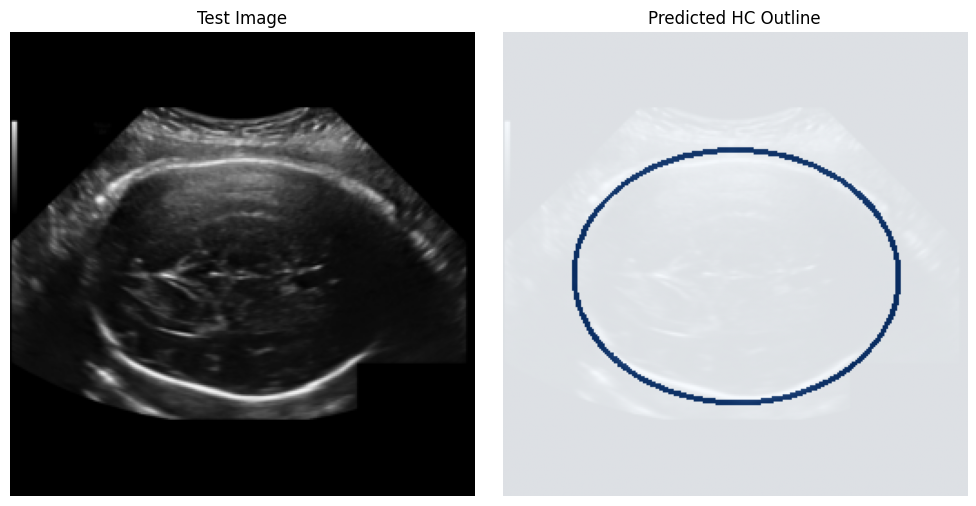

In [39]:
show_test_prediction(model, "test_set/004_HC.png")


In [40]:
import os
import cv2
import math
import numpy as np
import pandas as pd
import torch
from PIL import Image

resize_with_pad = ResizeWithPad(256)

# ---------- mask cleanup ----------
def clean_mask(mask):
    mask = (mask > 0).astype(np.uint8)

    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask, 8)

    if num_labels <= 1:
        return None

    largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
    clean = (labels == largest_label).astype(np.uint8)

    return clean


# ---------- ellipse HC ----------
def hc_from_mask(mask):
    mask = mask.astype(np.uint8) * 255

    contours, _ = cv2.findContours(
        mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE
    )

    if len(contours) == 0:
        return None

    cnt = max(contours, key=cv2.contourArea)

    if len(cnt) < 5:
        return None

    ellipse = cv2.fitEllipse(cnt)
    (_, _), (MA, ma), _ = ellipse

    return math.pi * (MA + ma) / 2


# ---------- compute HC ----------
model.eval()

df = pd.read_csv("test_set_pixel_size.csv")

hc_results = []

with torch.no_grad():
    for _, row in df.iterrows():

        filename = row["filename"]
        pixel_size = row["pixel size(mm)"]

        img_path = os.path.join("test_set", filename)

        img = Image.open(img_path).convert("RGB")
        img_np = np.array(img)

        # resize + pad
        img_resized = resize_with_pad(img_np)

        # 🔥 convert PIL -> numpy
        img_resized = np.array(img_resized)

        # numpy -> tensor
        img_tensor = torch.from_numpy(img_resized)\
                          .permute(2,0,1)\
                          .float()/255.0

        pred = model(img_tensor.unsqueeze(0).to(DEVICE))
        pred_mask = torch.sigmoid(pred)[0,0] > 0.5
        pred_mask = pred_mask.cpu().numpy()

        pred_mask = clean_mask(pred_mask)

        if pred_mask is None:
            hc_results.append(np.nan)
            continue

        hc_pixels = hc_from_mask(pred_mask)

        if hc_pixels is None:
            hc_results.append(np.nan)
            continue

        hc_mm = hc_pixels * pixel_size
        hc_results.append(hc_mm)


df["head circumference (mm)"] = hc_results
df.to_csv("test_set_pixel_size_and_HC.csv", index=False)

print("Saved: test_set_pixel_size_and_HC.csv")


Saved: test_set_pixel_size_and_HC.csv


In [41]:
import os
import cv2
import math
import numpy as np
import pandas as pd
import torch
from PIL import Image

resize_with_pad = ResizeWithPad(256)

SAVE_DIR = "test_set_pred_masks"
os.makedirs(SAVE_DIR, exist_ok=True)

# ---------- cleanup (use canonical) ----------
def clean_mask(mask):
    return canonical_clean_mask(mask)


# ---------- ellipse + HC (use canonical) ----------
def ellipse_and_hc(mask):
    ellipse = canonical_mask_to_ellipse(mask)
    if ellipse is None:
        return None, None
    return ellipse, canonical_hc_from_ellipse(ellipse)


# ---------- inference ----------
model.eval()

df = pd.read_csv("test_set_pixel_size.csv")

hc_results = []

with torch.no_grad():
    for _, row in df.iterrows():

        filename = row["filename"]
        pixel_size = row["pixel size(mm)"]

        img_path = os.path.join("test_set", filename)

        img = Image.open(img_path).convert("RGB")
        img_np = np.array(img)

        img_resized = resize_with_pad(img_np)
        img_resized = np.array(img_resized)

        img_tensor = torch.from_numpy(img_resized)\
                          .permute(2,0,1)\
                          .float()/255.0

        pred = model(img_tensor.unsqueeze(0).to(DEVICE))
        pred_mask = torch.sigmoid(pred)[0,0] > 0.5
        pred_mask = pred_mask.cpu().numpy()

        pred_mask = clean_mask(pred_mask)

        if pred_mask is None:
            hc_results.append(np.nan)
            continue

        ellipse, hc_pixels = ellipse_and_hc(pred_mask)

        if ellipse is None:
            hc_results.append(np.nan)
            continue

        # ---------- save ellipse mask ----------
        H, W = pred_mask.shape
        ellipse_mask = np.zeros((H, W), dtype=np.uint8)

        # thin white ellipse
        cv2.ellipse(ellipse_mask, ellipse, 255, thickness=2)

        save_path = os.path.join(SAVE_DIR, filename)
        cv2.imwrite(save_path, ellipse_mask)

        # HC in mm
        hc_mm = hc_pixels * pixel_size
        hc_results.append(hc_mm)


df["head circumference (mm)"] = hc_results
df.to_csv("test_set_pixel_size_and_HC.csv", index=False)

print("Masks saved to:", SAVE_DIR)
print("CSV saved: test_set_pixel_size_and_HC.csv")


Masks saved to: test_set_pred_masks
CSV saved: test_set_pixel_size_and_HC.csv
